### Costanti e funzioni utili in giro

In [49]:
TRAIN_DATASET_PATH = "/Users/vito/Desktop/sign_mnist_train/sign_mnist_train.csv"
TEST_DATASET_PATH = "/Users/vito/Desktop/sign_mnist_test/sign_mnist_test.csv"

# durante ogni iterazione dell'algoritmo di apprendimento,
# il modello viene aggiornato usando un insieme di campioni di dimensione BATCH_SIZE
BATCH_SIZE = 16

# numero classi presenti nel dataset (non sono 26 poichè mancano 2 lettere)
DATASET_CLASS_COUNT = 24

# numero canali delle immagini di train / test
DATASET_CHANNEL_COUNT = 1

# dimensioni immagini di train / test
DATASET_IMG_W = 28
DATASET_IMG_H = 28

### Carico il dataset con pandas
Il dataset è in formato CSV, ha una tabella di intestazione e dalla prima riga in poi è formato nel seguente modo:
- la prima cella contiene la label (dato che si tratta di apprendimento supervisionato è necessaria)
- le seguenti 784 celle indicate come pixel{n per 1 <= n <= 784} contengono ognuna il pixel dell'immagine in posizione n, sono 784 poichè tutte le immagini sono 28*28(=784)

In [50]:
import pandas as pd

# dataset train
df = pd.read_csv(TRAIN_DATASET_PATH)

# dataset test
test_df = pd.read_csv(TEST_DATASET_PATH)

# Stampo un piccolo sneak peak del dataset
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


0: A
1: B
2: C
3: D
4: E
5: F
6: G
7: H
8: I
10: K
11: L
12: M
13: N
14: O
15: P
16: Q
17: R
18: S
19: T
20: U
21: V
22: W
23: X
24: Y
[957, 1010, 1013, 1055, 1082, 1088, 1090, 1114, 1118, 1126, 1144, 1151, 1161, 1162, 1164, 1186, 1196, 1196, 1199, 1204, 1225, 1241, 1279, 1294]


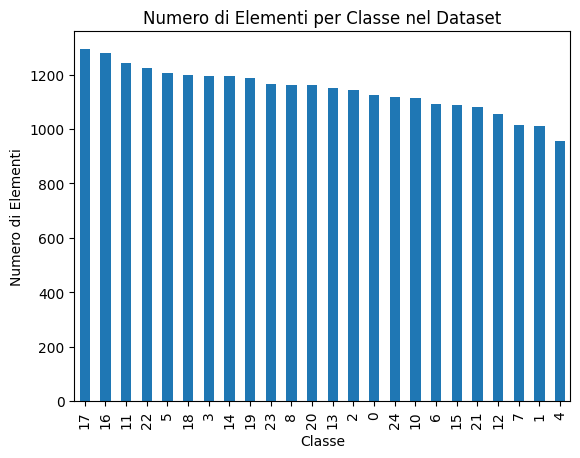

In [51]:
# Queste sono le label presenti nel dataset, sono gli indici delle lettere dell'alfabeto (tranne j e z poichè
# richiederebbero un movimento della mano)
labels = df['label'].unique()

def get_letter(letter: int) -> str:
    """
    Definisco questa funzione per trasformare facilmente l'indice
    della label nella lettera human readable
    """
    return chr(65 + letter)

print("\n".join([str(x) + ": " + str(get_letter(x)) for x in sorted(labels)]))

# Faccio il plot delle label per vedere se il dataset è sbilanciato verso una particolare label
import matplotlib.pyplot as plt

class_counts = df['label'].value_counts()
print(sorted(class_counts))

# Plotta il numero di elementi per ogni classe
plt.figure()
class_counts.plot(kind= 'bar')
plt.title('Numero di Elementi per Classe nel Dataset')
plt.xlabel('Classe')
plt.ylabel('Numero di Elementi')
plt.show()

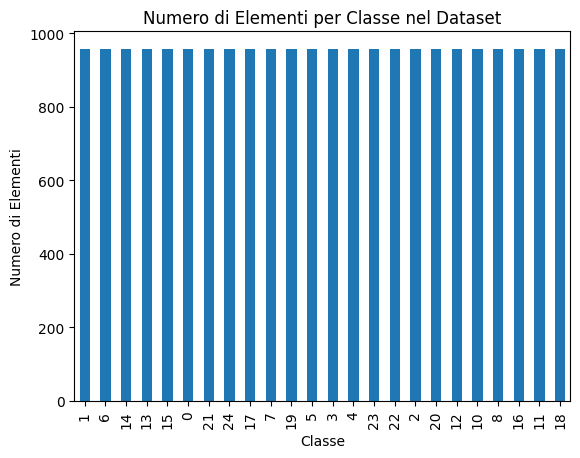

In [52]:
import pandas as pd
import numpy as np

# Calcola il numero minimo di elementi tra tutte le classi
min_class_count = df['label'].value_counts().min()

# Esegui l'undersampling per ogni classe
undersampled_df = pd.concat([
    df[df['label'] == label].sample(min_class_count, replace=False, random_state=42)
    for label in df['label'].unique()
])

# Effettuo lo shuffle del DataFrame risultante
undersampled_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

df = undersampled_df

# Ristampo il grafico
class_counts = df['label'].value_counts()

# Plotta il numero di elementi per ogni classe
plt.figure()
class_counts.plot(kind= 'bar')
plt.title('Numero di Elementi per Classe nel Dataset')
plt.xlabel('Classe')
plt.ylabel('Numero di Elementi')
plt.show()


In [53]:
train_features = df.iloc[:, 1:].values
train_labels = df.iloc[:, 0].values

train_original_shape = train_features.shape
print("[TRAIN] Original shape:", train_original_shape)

train_features = train_features.reshape(-1, 28, 28, 1)

# Normalizzo le features (che sono i pixel dell'immagine presi uno per uno)
train_features = train_features / 255.0

print("[TRAIN] Current shape:", train_features.shape)

[TRAIN] Original shape: (22968, 784)
[TRAIN] Current shape: (22968, 28, 28, 1)


In [54]:
import tensorflow as tf

print("[TRAIN] Inizializzo il dataset di allenamento")
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
# effettuo uno shuffle del dataset e lo divido in batch di dimensione [BATCH_SIZE]
# NB: si effettua lo shuffle per evitare problemi di bias di sequenza 
train_dataset = train_dataset.shuffle(buffer_size=len(train_features)).batch(BATCH_SIZE)

[TRAIN] Inizializzo il dataset di allenamento


### Creazione del modello
Aggiungo i layer convoluzionali necessari:
Conv2D: Il primo layer che si occupa dell'operazione di convoluzione, ossia far passare un kernel(filtro) di dimensione 3x3 nell'immagine per iniziare a mappare le caratteristiche dell'immagine. A questo layer è associata la funzione di attivazione ReLU che si occupa di introdurre non linearità (che vuol dire sostanzialmente che è come se il modello potesse decidere quando attivare o spegnere una caratteristica rendendo la rappresentazione più complessa in modo da capire meglio le immagini)
MaxPooling2D: il secondo layer è un layer di pooling, questi layer non imparano niente, ma si occupano di fare feature extraction, in questo caso maxpooling andrà a passare un kernel 2x2, selezionerà il pixel con il valore più alto e lo passerà al layer successivo, questo serve per togliere ancor di più possibile linearità e limitare overfitting.


Il layer di Flatten invece si occupa di convertire l'output della convoluzione in un vettore monodimensionale. Questo permette di passare dalla rappresentazione spaziale delle caratteristiche estratte dai filtri convoluzionali a una rappresentazione unidimensionale che può essere utilizzata dai layer densamente connessi.

I layer densamente connessi, chiamati così perchè ogni nodo (neurone) è connesso a tutti i nodi dello strato precedente.
L'ultimo layer, con funzione di attivazione softmax si occupa di creare una distribuzione di probabilità su tutte le classi di output (le 24 lettere)

In [55]:
from tensorflow.keras import layers, models

model = models.Sequential()

# layer convoluzionali
model.add(layers.Conv2D(64, (2, 2), activation='relu', input_shape=(DATASET_IMG_W, DATASET_IMG_H, DATASET_CHANNEL_COUNT)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (2, 2), activation='relu'))

# Appiattisco l'output e aggiungo i layer densi per l'output finale
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(25, activation='softmax'))

# Stampo un riassunto dei layer della rete neurale
model.summary()

model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 27, 27, 64)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 64)        16448     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 5, 5, 64)          16448     
                                                                 
 flatten_2 (Flatten)         (None, 1600)             

In [ ]:
train_result = model.fit(train_dataset, epochs=15)

print("[TRAIN] Allenamento completato, loss:", train_result.history['loss'][0], "accuracy:", train_result.history['accuracy'][0], sep=" ")

Epoch 1/15
1436/1436 [==============================] - 11s 7ms/step - loss: 0.8148 - accuracy: 0.7527
Epoch 2/15
1436/1436 [==============================] - 10s 7ms/step - loss: 0.0366 - accuracy: 0.9908
Epoch 3/15
 891/1436 [=================>............] - ETA: 3s - loss: 0.0216 - accuracy: 0.9945

In [ ]:
# Carica i dati di test
test_features = test_df.iloc[:, 1:].values
test_labels = test_df.iloc[:, 0].values

# Reshape delle features come nel dataset di allenamento
test_features = test_features.reshape(-1, DATASET_IMG_W, DATASET_IMG_H, DATASET_CHANNEL_COUNT)

# Normalizza le features
test_features = test_features / 255.0

# Crea un dataset di test
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))
test_dataset = test_dataset.batch(BATCH_SIZE)

# Valuta il modello sui dati di test
test_result = model.evaluate(test_dataset)

print("[TEST] Risultati sul dataset di test:")
print("[TEST] Loss:", test_result[0], ", Accuracy:", test_result[1], sep=" ")


In [ ]:
plt.plot(train_result.history['accuracy'])
plt.xlabel('epoch')
plt.plot(train_result.history['loss'])
plt.legend(['accuracy su dataset train','loss'])
plt.show()

In [ ]:
import numpy as np
from scipy import ndimage

foto = '/Users/vito/Desktop/screen.png'

test_image = tf.keras.preprocessing.image.load_img(foto, color_mode="grayscale", target_size=(28, 28))
test_image = tf.keras.preprocessing.image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0

import matplotlib.image as pltimg
img = pltimg.imread(foto)
plt.imshow(img)

pred = model.predict(test_image)
pclass = np.argmax(pred)
print("è la lettera", get_letter(pclass))
